In [5]:
import fastf1 as ff1
import pandas as pd
import sys
import os
sys.path.append(os.path.dirname("/home/ben/Individual_Project/DB"))
from DB.models import Circuit, RacingWeekend, Driver, Session, SessionResult, init_db
from database_operations import DatabaseOperations
from race_data import RaceDataSetup
from overtake_model import OvertakingModel

from race_dataframe import RaceDataframe
import matplotlib.pyplot as plt
import numpy as np

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None) 

In [6]:
db = DatabaseOperations(2024, "Sakhir")
race_dataframe = RaceDataframe(db)
race_setup = RaceDataSetup(db, race_dataframe)
overtake = OvertakingModel(race_dataframe.race_df)


/home/ben/Individual_Project/overtake_features/race_dataframe.py:110: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  race_df["next_pit"] = race_df["next_pit"].fillna(False)


Column 'driver_name' cannot be converted to float and will be removed.


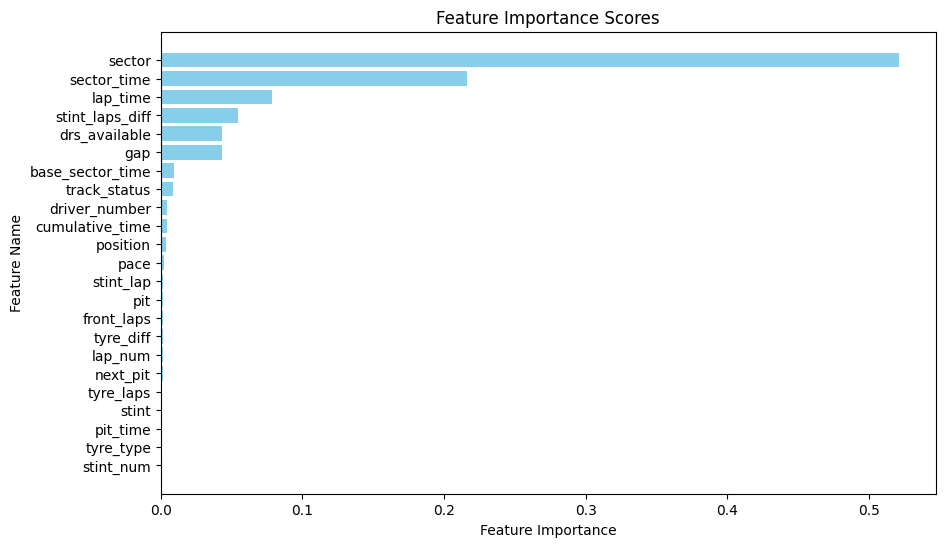

In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report

def remove_non_float_columns(df):
	"""
	Removes columns from the dataframe that cannot be fully converted to float.
	
	Args:
		df (pd.DataFrame): The input dataframe.
	
	Returns:
		pd.DataFrame: A new dataframe with only float-compatible columns.
	"""
	# Identify columns that cannot be converted to float
	float_compatible_columns = []
	for col in df.columns:
		try:
			# Attempt to convert the column to numeric (coerce errors to NaN)
			pd.to_numeric(df[col], errors='raise')
			float_compatible_columns.append(col)
		except ValueError:
			# If conversion fails, skip this column
			print(f"Column '{col}' cannot be converted to float and will be removed.")
	
	# Return a dataframe with only float-compatible columns
	return df[float_compatible_columns]

def preprocess_data(df, target_column):
    """
    Preprocess the data by encoding categorical variables, handling missing values, and resampling.
    
    Args:
        df (pd.DataFrame): The input dataframe.
        target_column (str): The name of the target column.
    
    Returns:
        X_resampled (np.ndarray): Resampled feature matrix.
        y_resampled (np.ndarray): Resampled target vector.
        feature_names (list): List of feature names.
    """
    # Separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]
    feature_names = X.columns.tolist()

    # Encode categorical columns
    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype.name == 'category':
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))

    # Handle missing values using SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    # Resample the data using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    return X_resampled, y_resampled, feature_names


def plot_feature_importance(X, y, feature_names):
    """
    Train a GradientBoostingClassifier and plot feature importances.
    
    Args:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Target vector.
        feature_names (list): List of feature names.
    """
    # Train a GradientBoostingClassifier
    gbc = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=42
    )
    gbc.fit(X, y)

    # Get feature importances
    feature_importances = gbc.feature_importances_

    # Sort features by importance
    sorted_indices = np.argsort(feature_importances)[::-1]
    sorted_features = [feature_names[i] for i in sorted_indices]
    sorted_importances = feature_importances[sorted_indices]

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importances, color='skyblue')
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.title("Feature Importance Scores")
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.show()


# Example usage
if __name__ == "__main__":
	# Load your dataframe here
	race_df = race_dataframe.race_df
	target_column = "overtaken"

	race_df = remove_non_float_columns(race_df)
	# Step 1: Preprocess the data
	X_resampled, y_resampled, feature_names = preprocess_data(race_df, target_column)

	# Step 2: Train model and select features
	plot_feature_importance(X_resampled, y_resampled, feature_names)
